# Contour Monte Carlo: TNF signalling pathway
This Julia notebook demonstrates how to perform Contour Monte Carlo to estimate cell population heterogeneity for the tumour necrosis factor signalling model in Lambert et al., 2019. Note that the code uses the `RCall` Julia package to call R, in order to use the vine copula kernel density estimation available in the R package `kdevine`.

In [1]:
using RCall, Compat, Random, Distributions, Plots, DifferentialEquations, LinearAlgebra, Plots, DelimitedFiles

R"library(kdevine)"
    
function f_solve(f_deriv, initial, tspan, parameters)
    prob = ODEProblem(f_deriv, initial, tspan, parameters)
    sol = solve(prob)
    return sol
end

function f_sample_solve_uniform(num_samples, population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, initial, tspan, samples[i, :]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_sample_solve_uniform_uncertain_inits(num_samples, population_sample, times_solve,
        tspan, f_solve, f_deriv, bounds, nparams, ninits)
    n_params = size(bounds)[1]
    samples = zeros((num_samples, n_params))
    for i = 1:n_params
        samples[:, i] = rand(Uniform(bounds[i, 1], bounds[i, 2]), num_samples)
    end
    mOutputs = zeros((num_samples, length(population_sample)))
    for i in 1:num_samples
        sol = f_solve(f_deriv, samples[i, (nparams + 1):(nparams + ninits)], tspan, samples[i, 1:nparams]);
        for j = 1:length(population_sample)
           mOutputs[i, j] = sol(times_solve[j], idxs=population_sample[j])
        end
    end
    return mOutputs
end

function f_estimate_kdevine(mOutputs)
    @rput mOutputs
    R"fit <- kdevine(mOutputs)"
end

function dkdevine(params)
    @rput params
    R"z <- dkdevine(params, fit)"
    @rget z
    return z
end

function load_dkdevine_fit()
    R"z <- readRDS('../data/vine_fit.RDS')"
    @rget z
    return z
end

function f_step_bounds(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = (rand(Normal(vCurrent[i] - bounds[i, 1], sigma[i]), 1)[1] % (bounds[i, 2] - bounds[i, 1]))
        if temp < 0
            temp += bounds[i, 2]
        else
            temp += bounds[i, 1]
        end
        vProposed[i] = temp
    end
    return vProposed
end

function f_step_bounds_simple(vCurrent, bounds, sigma)
    vProposed = zeros(size(bounds)[1])
    for i = 1:length(vProposed)
        temp = rand(Normal(vCurrent[i], sigma[i]), 1)[1]
        vProposed[i] = temp
    end
    return vProposed
end

function f_mcmc_uniform_uncertain_ints(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, mInputs[1, (nparams + 1):(nparams + ninits)], tspan, mInputs[1, 1:nparams]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * (nparams + ninits))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, vProposed[(nparams + 1):(nparams + ninits)], tspan, vProposed[1:nparams]);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * (nparams + ninits))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, vProposed[(nparams + 1):(nparams + ninits)], tspan, vProposed[1:nparams]);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_mcmc_uniform(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (100 * length(initial_inputs))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (100 * length(initial_inputs))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_log_pdf(v_values, v_dist)
    log_pdf = 0.0
    k = 1
    for val in v_values
        log_pdf += logpdf(v_dist[k], val)
        k += 1
    end
    return log_pdf
    end

function f_mcmc_uniform_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial))
    end
    return vResults
end

function f_mcmc_uniform_uncertain_ints_multiple(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform_uncertain_ints(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, nparams, ninits))
    end
    return vResults
end

function f_between(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    mMeans = zeros((nchains, nparams));
    for i = 1:nchains
        inputs = vResults[i]["inputs"];
        for j = 1:nparams
            mMeans[i, j] = mean(inputs[:, j]);
        end
    end
    t = size(inputs)[1];
    vOverallMean = mean(mMeans, dims=1);
    vVar = (t / (nchains - 1)) * sum((mMeans .- vOverallMean).^2, dims=1);
    return vVar
end

function f_within(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    mVars = zeros((nchains, nparams));
    for i = 1:nchains
        inputs = vResults[i]["inputs"];
        for j = 1:nparams
            mVars[i, j] = var(inputs[:, j]);
        end
    end
    return mean(mVars, dims=1)
end

function f_rhat(vResults)
    nchains = length(vResults)
    inputs = vResults[1]["inputs"];
    nparams = size(inputs)[2];
    t = size(inputs)[1];
    vWithin = f_within(vResults);
    vBetween = f_between(vResults);
    return sqrt.((vBetween ./ t + vWithin) ./ vWithin)
end


R version 3.4.2 (2017-09-28) -- "Short Summer"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



┌ Warning: RCall.jl: Warning: package 'kdevine' was built under R version 3.4.4
│ The kdevine package is no longer actively developed. Consider using 
│    - the 'kde1d' package for marginal estimation, 
│    - the functions vine() and vinecop() from the 'rvinecopulib' 
│      package as replacements for kdevine() and kdevincop().
└ @ RCall C:\Users\bclamber\.julia\packages\RCall\ffM0W\src\io.jl:113


f_rhat (generic function with 1 method)

TNF functions.

In [2]:
function inh(x, b)
    return b^2 / (x^2 + b^2)
end

function act(x, a)
    return x^2 / (a^2 + x^2)
end

function u(t)
    if t < 2
        return 1.0
    else
        return 0.0
    end
end

function deriv_tnf_signalling(dxdt, y, p, t)
    a1=p[1]; a2=p[2]; a3=p[3]; a4=p[4];
    b1=p[5]; b2=p[6]; b3=p[7]; b4=p[8]; b5=p[9];
    x1=y[1]; x2=y[2]; x3=y[3]; x4=y[4];
    dxdt[1] = -x1 + 0.5 * (inh(x3, b4) * act(u(t), a1) + act(x2, a3))
    dxdt[2] = -x2 + act(x1, a2) * inh(x3, b3)
    dxdt[3] = -x3 + inh(x2, b2) * inh(x4, b5)
    dxdt[4] = -x4 + 0.5 * (inh(u(t), b1) + act(x3, a4))
end

deriv_tnf_signalling (generic function with 1 method)

## Recovering parameter values in under-determined systems

Generate output data from forward simulations and estimate mean and covariance matrix.

In [3]:
n = 10000
tspan = (0.0, 11.0)
mOutputs = zeros((n, 2))
samples = rand(Normal(0.6, 0.05), n)
for i = 1:n
    sol = f_solve(deriv_tnf_signalling, [0.0; 0.0; 0.29; 0.625], tspan, [samples[i], 0.2, 0.2, 0.5, 0.4, 0.7, 0.3, 0.5, 0.4]);
    mOutputs[i, :] = [sol(2, idxs=1), sol(1, idxs=2)]
end
histogram(mOutputs)

mu = mean(mOutputs, dims=1)
sigma1 = cov(mOutputs)
println(mu)
println(sigma1)

[0.25731 0.0666344]
[0.000213468 6.08803e-5; 6.08803e-5 1.815e-5]


Estimate contour volumes.

In [4]:
ncontourvolsamples = 10000
mBounds = [[0.4 0.8]; [0.1 0.7]; [0.3 0.7]; [0.1 0.3]; [0.5 0.7]; [0.4 0.6]; [0.4 0.6]; [0.2 0.4]; [0.2 0.4]];
[0.6, 0.2, 0.2, 0.5, 0.6, 0.7, 0.3, 0.5, 0.4]
tspan = (0.0, 11.0)
initial = [0.0; 0.0; 0.29; 0.625];
populations_observed = [1, 2]
times_observed = [2, 1]

mOutputs = @time f_sample_solve_uniform(ncontourvolsamples, populations_observed, times_observed,
    tspan, f_solve, deriv_tnf_signalling,
    mBounds, initial);

@time f_estimate_kdevine(mOutputs);

  3.482670 seconds (8.09 M allocations: 627.163 MiB, 6.75% gc time)
 22.018497 seconds (222.46 k allocations: 11.309 MiB)


Perform MCMC targeting the output distribution generated by forwad simulations.

In [6]:
function f_tnf_circular(v_values)
    dist_1 = MvNormal([0.25715, 0.0666113], [[0.000208208 5.91441e-5]; [5.91441e-5 1.75967e-5]])
    return logpdf(dist_1, v_values)
end

nchains = 4
nsamples = 5000
initial_parameters = [0.6, 0.2, 0.4, 0.2, 0.6, 0.5, 0.5, 0.3, 0.3];
sigma = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

vResults = @time f_mcmc_uniform_multiple(nchains, nsamples, f_tnf_circular, dkdevine,
    sigma, populations_observed, times_observed, tspan, f_solve,
    deriv_tnf_signalling, mBounds, initial_parameters, initial);

143.364696 seconds (25.60 M allocations: 1.671 GiB, 0.71% gc time)


Histogram of parameter samples.

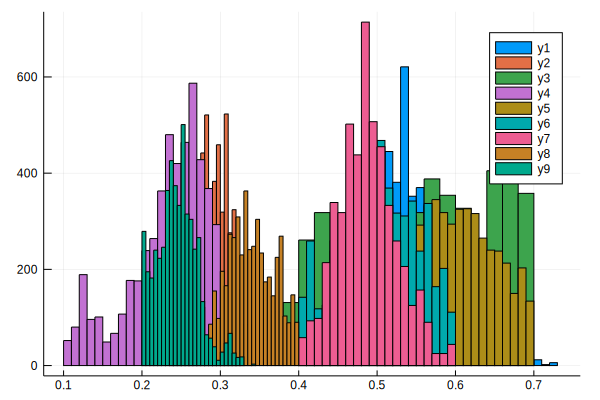

In [14]:
histogram(vResults[1]["inputs"])

### Bimodal output distribution

Perform contour volume estimation.

In [15]:
ncontourvolsamples = 100000
mBounds = [[0.5 0.7]; [0.1 0.3]; [0.1 0.3]; [0.4 0.6]; [0.3 0.5]; [0.6 0.8]; [0.2 0.4]; [0.4 0.6]; [0.3 0.5]];


tspan = (0.0, 11.0)
initial = [0.0; 0.0; 0.29; 0.625];
populations_observed = [2, 2, 2]
times_observed = [1, 2, 4]

mOutputs = @time f_sample_solve_uniform(ncontourvolsamples, populations_observed, times_observed,
    tspan, f_solve, deriv_tnf_signalling,
    mBounds, initial);

@time f_estimate_kdevine(mOutputs);

@time load_dkdevine_fit();

 32.010195 seconds (82.85 M allocations: 6.167 GiB, 5.43% gc time)
2244.079136 seconds (81 allocations: 2.375 KiB)
  1.014816 seconds (1.60 M allocations: 108.203 MiB, 4.82% gc time)


Perform MCMC.

In [16]:
function f_mcmc_uniform1(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    mInputs = zeros((num_samples, size(bounds)[1]))
    mOutputs = zeros((num_samples, length(population_sample)))
    vOutputs_temp = zeros(length(population_sample))
    vLogPDF = zeros(num_samples)
    vContour = zeros(num_samples)
    # initial points
    mInputs[1, :] = initial_inputs
    for j = 1:length(population_sample)
        sol = f_solve(f_deriv, initial, tspan, mInputs[1, :]);
        mOutputs[1, j] = sol(times_solve[j], idxs=population_sample[j])
    end
    log_pdf_current = target_fn(mOutputs[1, :])
    log_contour_current = log(f_dkdevine(mOutputs[1, :]))
    # MCMC
    log_a = 0.0
    sigma = Matrix(Diagonal(sigma.^2))
    mu = initial_inputs
    for i = 2:num_samples
        if i <= (10000 * length(initial_inputs))
            vProposed = rand(MvNormal(mInputs[i - 1, :], sigma), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
        else
            s = i - (10000 * length(initial_inputs))
            gamma = (s + 1)^(-0.6)
            vProposed = rand(MvNormal(mInputs[i - 1, :], Matrix(Hermitian(sigma)) * exp(log_a)), 1)
            if (sum(vProposed .< bounds[:, 1]) > 0) || (sum(vProposed .> bounds[:, 2]) > 0)
                mInputs[i, :] = mInputs[i - 1, :]
                mOutputs[i, :] = mOutputs[i - 1, :]
                accepted = 0.0
            else
                sol = f_solve(f_deriv, initial, tspan, vProposed);
                for j = 1:length(population_sample)
                    vOutputs_temp[j] = sol(times_solve[j], idxs=population_sample[j]);
                end
                log_pdf_proposed = target_fn(vOutputs_temp)
                log_contour_proposed = log(f_dkdevine(vOutputs_temp))
                log_r = ((log_pdf_proposed + log_contour_current) -
                         (log_pdf_current + log_contour_proposed))
                if (log_r > log(rand(Uniform(), 1)[1])) && (log_contour_proposed > -4)
                    mInputs[i, :] = vProposed
                    mOutputs[i, :] = vOutputs_temp
                    log_pdf_current = log_pdf_proposed
                    log_contour_current = log_contour_proposed
                    accepted = 1.0
                else
                    mInputs[i, :] = mInputs[i - 1, :]
                    mOutputs[i, :] = mOutputs[i - 1, :]
                    accepted = 0.0
                end
            end
            vLogPDF[i] = log_pdf_current
            vContour[i] = log_contour_current
            sigma = (1 - gamma) * sigma + gamma * (mInputs[i, :] - mu) * (mInputs[i, :] - mu)'
            mu = (1 - gamma) * mu + gamma * mInputs[i, :]
            log_a += gamma * (accepted - 0.25)
        end
    end
    return Dict("inputs" => mInputs, "outputs" => mOutputs, "log_pdf" => vLogPDF, "contour_volume" => vContour)
end

function f_mcmc_uniform_multiple1(nchains, num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial)
    vResults = []
    for i = 1:nchains
         push!(vResults, f_mcmc_uniform1(num_samples, target_fn, f_dkdevine, sigma,
        population_sample, times_solve, tspan, f_solve, f_deriv, bounds, initial_inputs, initial))
    end
    return vResults
end

vResults = @time f_mcmc_uniform_multiple1(nchains, nsamples, f_tnf_bimodal, dkdevine,
    sigma, populations_observed, times_observed, tspan, f_solve,
    deriv_tnf_signalling, mBounds, initial_parameters, initial);

UndefVarError: UndefVarError: f_tnf_bimodal not defined

Check convergence diagnostics.

In [17]:
println(f_rhat(vResults))

[1.14202 1.32926 1.4921 1.06238 1.04976 1.04451 1.01919 1.09529 1.10557]


Histogram of output values.

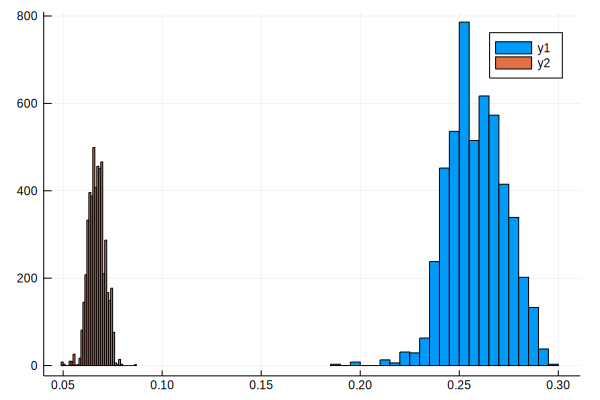

In [18]:
histogram(vResults[1]["outputs"])